<a href="https://colab.research.google.com/github/agustingrigoriu/HN-Search/blob/master/pento_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from keras.applications import MobileNetV2



from google.colab import files, drive

from PIL import Image, ImageFilter

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_image_info(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        aspect_ratio = width / height
        size = os.path.getsize(image_path)
        color_model = img.mode
        img_array = np.array(img)
        return width, height, aspect_ratio, size, color_model, img_array


def create_image_dataframe(root_dir):
    data = []
    for subdir, _, files in os.walk(root_dir):
        label = os.path.basename(subdir)
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                image_path = os.path.join(subdir, file)
                file_extension = os.path.splitext(file)[1]
                width, height, aspect_ratio, size, color_model, img_array = get_image_info(image_path)
                data.append({
                    'image_path': image_path,
                    'label': label,
                    'file_extension': file_extension,
                    'aspect_ratio': aspect_ratio,
                    'size': size,
                    'width': width,
                    'height': height,
                    'color_model': color_model,
                })
    return pd.DataFrame(data)

def visualize_images(df, n_examples=5, column_name='image_array', is_normalized=False):
    labels = df['label'].unique()

    n_rows = len(labels)

    fig, axes = plt.subplots(n_rows, n_examples, figsize=(15, n_rows * 3))

    for i, label in enumerate(labels):
        examples = df[df['label'] == label].sample(n_examples)

        for j, (index, row) in enumerate(examples.iterrows()):
            img = Image.open(row['image_path'])

            axes[i, j].imshow(img)
            axes[i, j].axis('off')

        axes[i, 0].set_title(label, size=15)

    plt.tight_layout()
    plt.show()

In [ ]:
images_dir_path = '/content/drive/MyDrive/Colab Notebooks/dogs'
images_df = create_image_dataframe(images_dir_path)

In [ ]:
images_df.head()

,image_path,label,file_extension,aspect_ratio,size,width,height,color_model
0,/content/drive/MyDrive/Colab Notebooks/dogs/po...,poodle,.jpg,0.805003,201907,1255,1559,RGB
1,/content/drive/MyDrive/Colab Notebooks/dogs/po...,poodle,.jpg,0.714286,387263,1200,1680,RGB
2,/content/drive/MyDrive/Colab Notebooks/dogs/po...,poodle,.jpg,0.651075,207840,1030,1582,RGB
3,/content/drive/MyDrive/Colab Notebooks/dogs/po...,poodle,.jpg,1.504113,147959,1280,851,RGB
4,/content/drive/MyDrive/Colab Notebooks/dogs/po...,poodle,.jpg,0.864654,352822,1661,1921,RGB


# Analysis

## Images Visualization

Visualizing images before preprocessing and classification is crucial for understanding data characteristics, identifying issues like mislabeled images, and ensuring preprocessing techniques are correctly applied. Therefore, improving model accuracy and performance.

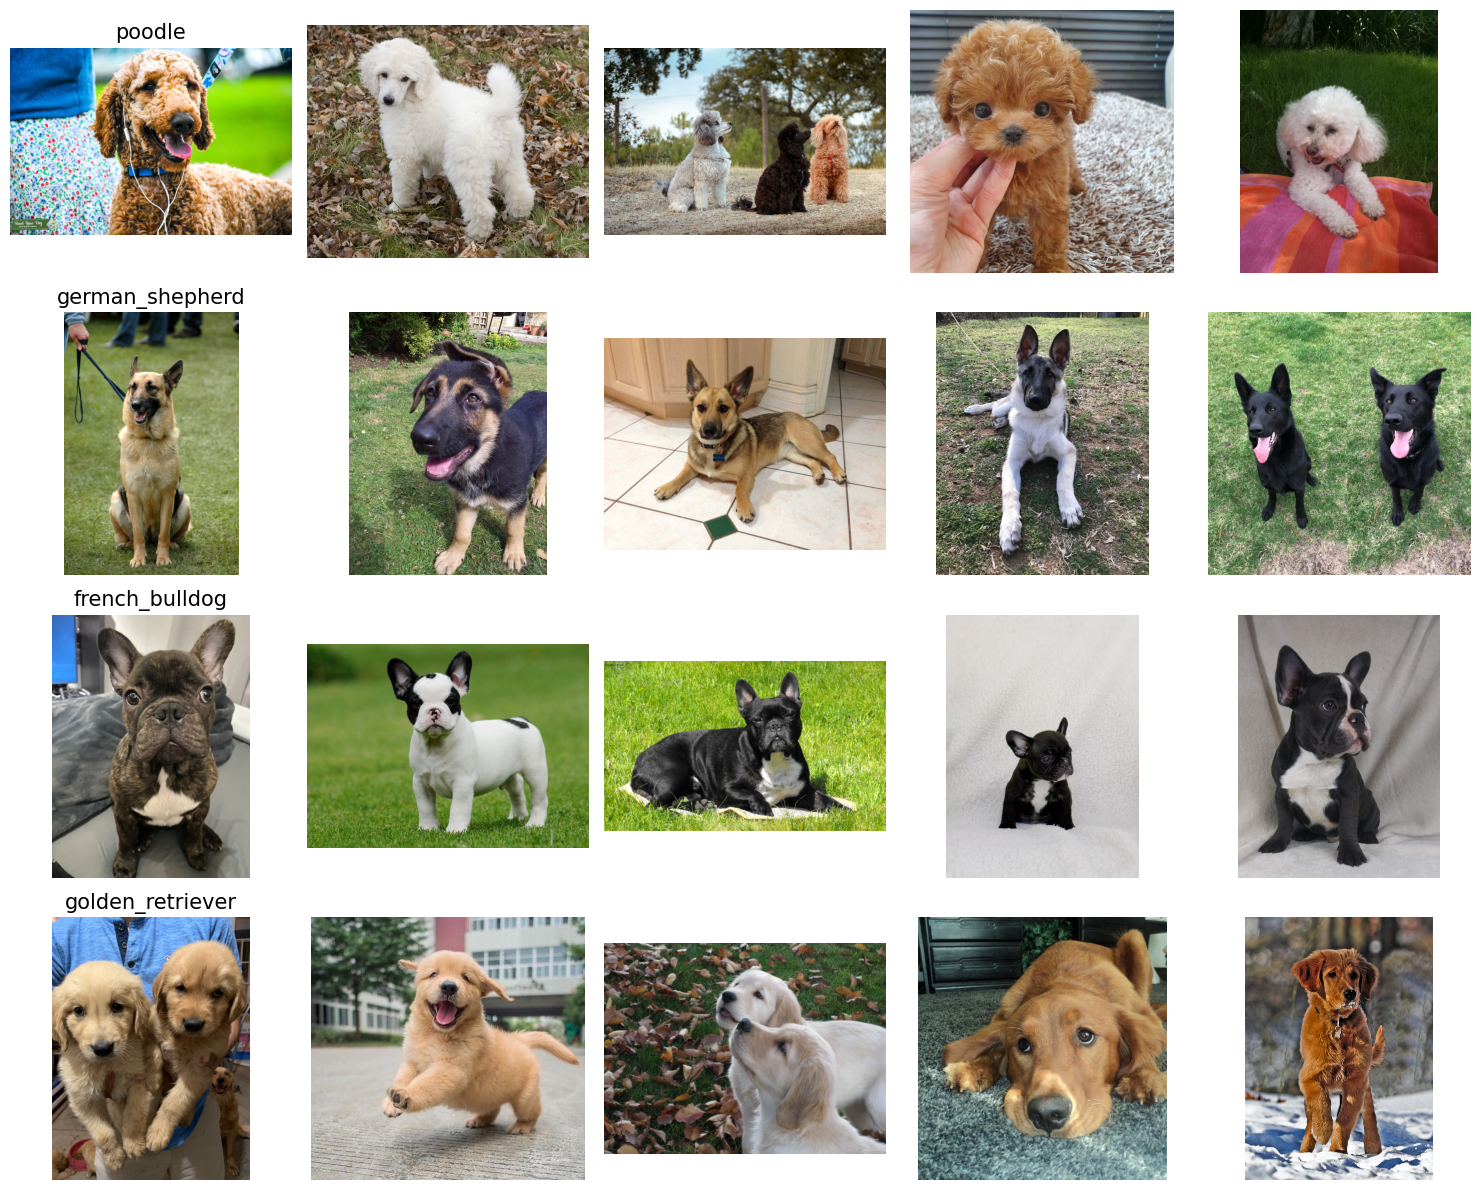

In [ ]:
visualize_images(images_df)

## Class Imbalance and dataset size
An imbalanced dataset would introduce bias towards the majority class when we run our algorithms. Although this is provided in the case study, its always a good practice to visualize how many examples of each class we have in the dataset.


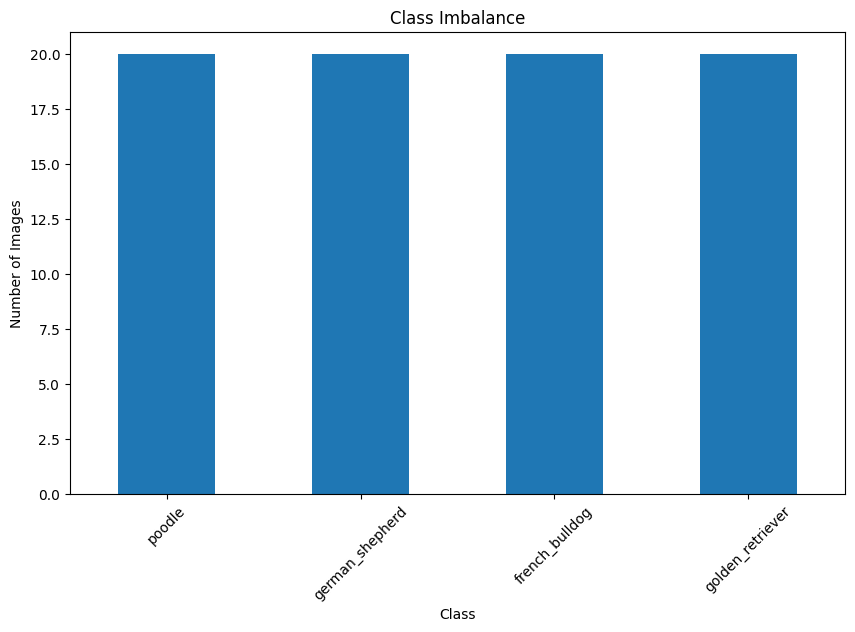

In [ ]:
class_counts = images_df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Imbalance')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

The results will show that there is no class imbalance. Therefore we don't have to take action to balance the classes.

But we have an issue, the dataset is pretty small. Data augmentation could help us increase the dataset with new images created from the existing ones. The new images would be modified (for instance, rotated).

Note:

The augmentation is only applied to the training set.

## Image dimensions


Image resolution is important to check before running a CNN to ensure images have sufficient detail for accurate feature extraction and classification.


Knowing the aspect ratio distribution in a dataset is also important because it affects how images are resized. Different aspect ratios can lead to image distortion when standardized, impacting model performance. By checking this distribution, you can choose the best preprocessing methods to preserve image quality, helping the model learn better from the data.

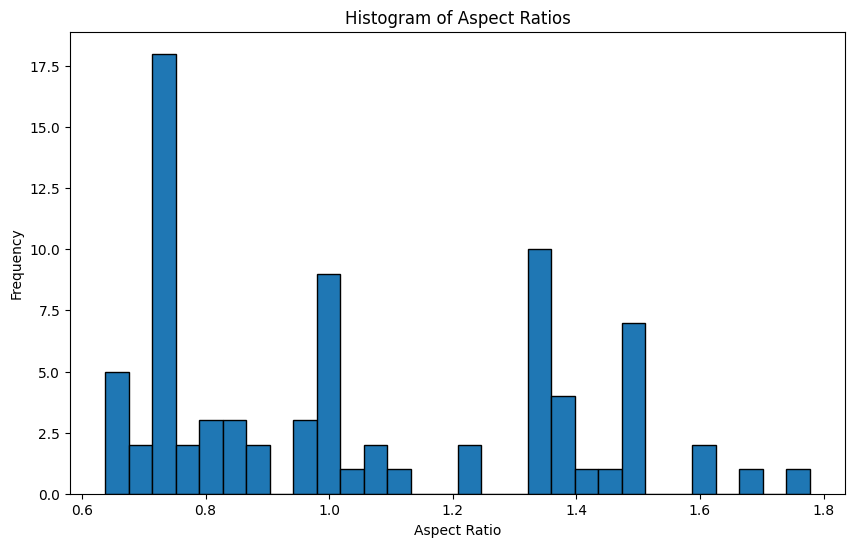

In [ ]:
aspect_ratios = images_df['aspect_ratio']

plt.figure(figsize=(10, 6))
plt.hist(aspect_ratios, bins=30, edgecolor='black')
plt.title('Histogram of Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

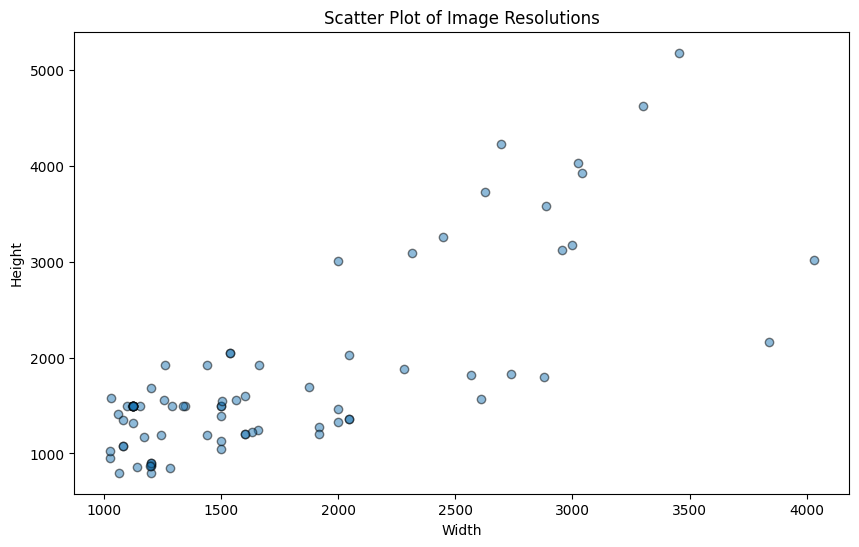

In [ ]:
widths = images_df['width']
heights = images_df['height']

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, edgecolor='black')
plt.title('Scatter Plot of Image Resolutions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [ ]:
median_width = images_df['width'].median()
median_height = images_df['height'].median()

print(f"Median width: {median_width}")
print(f"Median height: {median_height}")

Median width: 1500.0
Median height: 1500.0


## Color model

In this case, it matters whether we have a RGB or Grayscale color model. Some dog breeds are associated with specific colors that will help us classify them better. **All** images are using RGB.

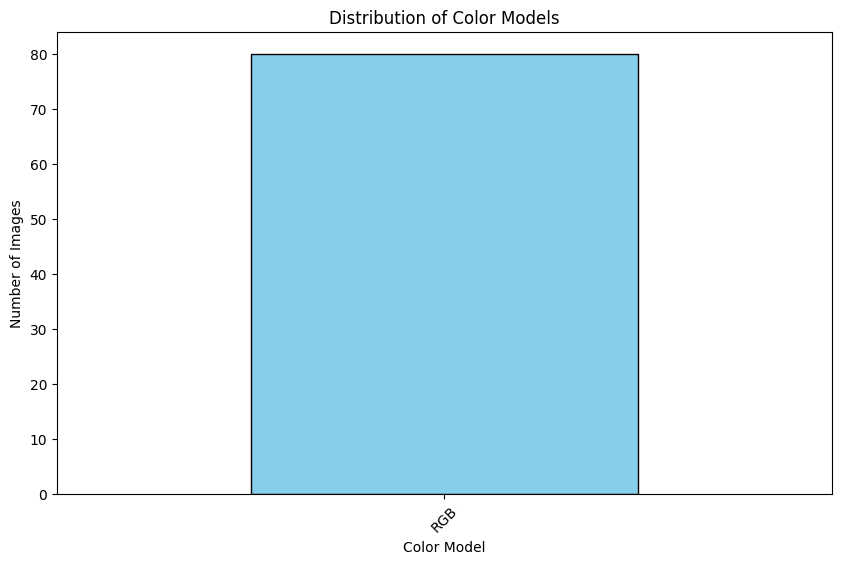

In [ ]:
color_model_counts = images_df['color_model'].value_counts()

plt.figure(figsize=(10, 6))
color_model_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Color Models')
plt.xlabel('Color Model')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Pre-Processing

The amount of data is low. So we could augment the dataset by creating duplicates of the images with slight variations.

Also, if we decided to add more examples to our dataset, we wouldn't be able to fit all in memory.

The following piece of code creates "iterators" that generate those variations on the fly. The model can consume this when training.



In [ ]:
model_path = '/content/drive/MyDrive/dog_breed_classifier.keras'

batch_size = 32
input_height = 224
input_width = 224
channels = 3
image_size = (input_height, input_width)
image_shape = (input_height, input_width, channels)
num_classes = len(images_df['label'].unique())
labels_dict = {0: 'french_bulldog', 1: 'german_shepherd', 2: 'golden_retriever', 3: 'poodle'}

In [ ]:
df_train, df_val = train_test_split(images_df, test_size=0.20, random_state=42, stratify=images_df['label'])

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.5,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.1, 1.5],
    rescale=1./255,
    fill_mode="constant"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=None,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
)

Found 64 validated image filenames belonging to 4 classes.
Found 16 validated image filenames belonging to 4 classes.


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [ ]:
def print_image_generator_samples(generator):
  images, labels = next(generator)

  plt.figure(figsize=(10, 10))
  for i in range(5):
      plt.subplot(1, 5, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel(labels_dict[np.argmax(labels[i])])
  plt.show()


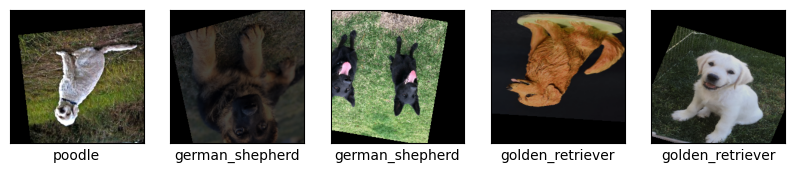

In [ ]:
print_image_generator_samples(train_generator)

In [ ]:
class_indices = train_generator.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
print(class_indices)
print(index_to_label)

{'french_bulldog': 0, 'german_shepherd': 1, 'golden_retriever': 2, 'poodle': 3}
{0: 'french_bulldog', 1: 'german_shepherd', 2: 'golden_retriever', 3: 'poodle'}


## CNN

In [ ]:
basic_cnn_model = Sequential()

basic_cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(MaxPooling2D(pool_size=(2,2)))

basic_cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(MaxPooling2D(pool_size=(2,2)))
basic_cnn_model.add(Dropout(0.25))

basic_cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(MaxPooling2D(pool_size=(2,2)))
basic_cnn_model.add(Dropout(0.25))

basic_cnn_model.add(Flatten())
basic_cnn_model.add(Dense(256, activation='relu'))
basic_cnn_model.add(Dropout(0.5))
basic_cnn_model.add(Dense(num_classes, activation='softmax'))

basic_cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
basic_cnn_model_history = basic_cnn_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, early_stopping]
)

In [ ]:
losses = pd.DataFrame(basic_cnn_model_history.history)
losses[['accuracy','val_accuracy']].plot()

NameError: name 'basic_cnn_model_history' is not defined

Since the dataset is too small, I will add a pretrained set to the pipeline. And train the model on top of it.

In [ ]:
base_mobile_net_v2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)
for layer in base_mobile_net_v2_model.layers:
    layer.trainable = False

pretrained_model = Sequential()
pretrained_model.add(base_mobile_net_v2_model)
pretrained_model.add(Flatten())
pretrained_model.add(Dense(256, activation='relu'))
pretrained_model.add(Dropout(0.5))
pretrained_model.add(Dense(num_classes, activation='softmax'))

pretrained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
pretrained_model_history = pretrained_model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/200
2/2 [==============================] - 15s 5s/step - loss: 8.8857 - accuracy: 0.3594 - val_loss: 7.2928 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/200
2/2 [==============================] - 9s 5s/step - loss: 24.5222 - accuracy: 0.4062 - val_loss: 0.0588 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/200
2/2 [==============================] - 7s 3s/step - loss: 11.3348 - accuracy: 0.6094 - val_loss: 3.5244 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/200
2/2 [==============================] - 9s 4s/step - loss: 16.0347 - accuracy: 0.4844 - val_loss: 1.5702 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/200
2/2 [==============================] - 9s 4s/step - loss: 5.5283 - accuracy: 0.7344 - val_loss: 0.4072 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/200
2/2 [==============================] - 7s 3s/step - loss: 7.4193 - accuracy: 0.7188 - val_loss: 0.3587 - val_accuracy: 0.9375 - lr: 2.0000e-04
Epoch 7/200
2/2 [==============================] - 11s 6s/step - loss: 6.7412 - accura

<Axes: >

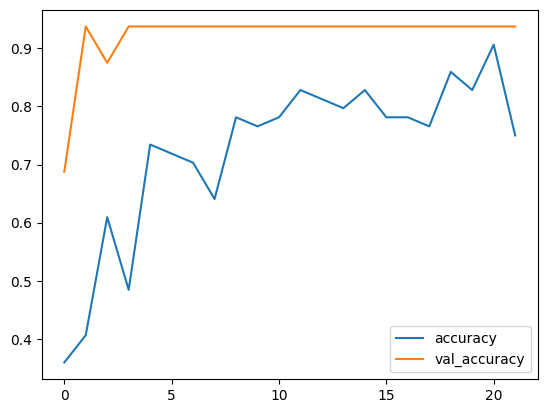

In [ ]:
losses = pd.DataFrame(pretrained_model_history.history)
losses[['accuracy','val_accuracy']].plot()

# Saving the selected model

In [ ]:
# pretrained_model.save(model_path)

# Manual Test

We will load the model stored in the disk. And we will provide an option to upload a set of images and classify them.

If the best prediction value is lower than a threshold, we will classify it as "other". I thought this was the most straightforward approach to classify images that are unrelated to the four breeds provided in the dataset.

In [ ]:
pretrained_model = tf.keras.models.load_model(model_path)

In [ ]:
tolerance = 0.0001

def upload_and_predict_images(model):
  uploaded = files.upload()

  for fn in uploaded.keys():
    img = Image.open(fn).convert('RGB')
    img = img.resize(image_size)
    x = np.array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    pred_class_index = preds.argmax()
    pred_value = preds[0][pred_class_index]
    print(preds)
    pred_class = 'other' if  (1.0 - pred_value) > tolerance else labels_dict[pred_class_index]

    print(pred_class)

    plt.imshow(img)
    plt.title(f"Label: {pred_class}")
    plt.show()


Saving Screenshot 2024-07-09 at 8.17.54 PM.png to Screenshot 2024-07-09 at 8.17.54 PM.png
1/1 [==============================] - 0s 63ms/step
[[9.9999619e-01 3.7590889e-06 1.5935294e-20 4.7245452e-10]]
french_bulldog


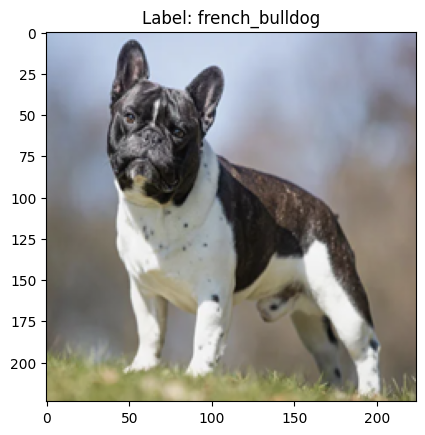

In [ ]:
upload_and_predict_images(pretrained_model)

# Conclusion

Choosing a pretrained MobileNetV2 model for a small dataset is beneficial because it leverages the model's existing knowledge from being trained on a large dataset like ImageNet.

This helps in extracting useful features quickly and reduces the chances of overfitting.

Additionally, it cuts down on training time and resources while still providing strong performance, making it an efficient choice for working with limited data.

If I had more resources, I would apply multiple models, evaluate and compare them.

The "other" tag was introduced in the predict function. I tested multiple images downloaded from the internet, and multiple tolerance values. If the prediction is not good enough, it will label it as "other".
